In [1]:
!pip install --quiet scikit-learn sentence_transformers pandas wordcloud


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import sklearn
import nltk
import re
import numpy as np

from matplotlib import pyplot as plt
from nltk import tokenize
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from wordcloud import WordCloud, STOPWORDS

In [4]:
train_df = pd.read_csv('datasets/train.csv')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ChannelName       587 non-null    object
 1   ChannelId         587 non-null    int64 
 2   MessageId         587 non-null    int64 
 3   Date              587 non-null    object
 4   EditDate          573 non-null    object
 5   Content           587 non-null    object
 6   Suspicious_Level  587 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 32.2+ KB


In [6]:
test_df = pd.read_csv('datasets/test.csv')

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ChannelName  1171 non-null   object
 1   ChannelId    1171 non-null   int64 
 2   MessageId    1171 non-null   int64 
 3   Date         1171 non-null   object
 4   EditDate     884 non-null    object
 5   Content      1171 non-null   object
dtypes: int64(2), object(4)
memory usage: 55.0+ KB


In [8]:
train_df.head(n=3)

ChannelName   ChannelId  MessageId                 Date  \
0  boris_rozhin  1101806611      91626  2023-07-08 16:11:34   
1     sashakots  1109403194      40853  2023-07-08 16:44:44   
2        swodki  1144180066     280668  2023-07-09 02:00:23   

              EditDate                                            Content  \
0  2023-07-08 16:11:47  –†–∞–±–æ—Ç–∞ –Ω–∞—à–∏—Ö –±–æ–π—Ü–æ–≤ –∫ —é–≥—É –æ—Ç –ê—Ä—Ç–µ–º–æ–≤—Å–∫–∞. –†–∞–±–æ—Ç...   
1  2023-07-08 16:44:58  –ê–Ω–∫–∞—Ä–∞ –Ω–∞—Ä—É—à–∏–ª–∞ –¥–æ–≥–æ–≤–æ—Ä—ë–Ω–Ω–æ—Å—Ç–∏, –æ—Ç–ø—É—Å—Ç–∏–≤ –≥–ª–∞–≤–∞...   
2  2023-07-09 02:05:53  –≠–¢–û –ï–î–ò–ù–°–¢–í–ï–ù–ù–´–ô –°–ü–û–°–û–ë –ü–û–ú–û–ß–¨ –ù–ê–ú! \n\n–ü–æ–ø–æ–ª–Ω...   

   Suspicious_Level  
0                 2  
1                 1  
2                 1

### Preprocessing

In [9]:
nltk.download('punkt')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^–∞-—è–ê-–Øa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~—ë]+", " ", input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        # input = input.lower()
    return input

[nltk_data] Downloading package punkt to /Users/danorel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
train_df["Content_processed"] = train_df["Content"].apply(process_text)

In [11]:
train_df.head(n=3)

ChannelName   ChannelId  MessageId                 Date  \
0  boris_rozhin  1101806611      91626  2023-07-08 16:11:34   
1     sashakots  1109403194      40853  2023-07-08 16:44:44   
2        swodki  1144180066     280668  2023-07-09 02:00:23   

              EditDate                                            Content  \
0  2023-07-08 16:11:47  –†–∞–±–æ—Ç–∞ –Ω–∞—à–∏—Ö –±–æ–π—Ü–æ–≤ –∫ —é–≥—É –æ—Ç –ê—Ä—Ç–µ–º–æ–≤—Å–∫–∞. –†–∞–±–æ—Ç...   
1  2023-07-08 16:44:58  –ê–Ω–∫–∞—Ä–∞ –Ω–∞—Ä—É—à–∏–ª–∞ –¥–æ–≥–æ–≤–æ—Ä—ë–Ω–Ω–æ—Å—Ç–∏, –æ—Ç–ø—É—Å—Ç–∏–≤ –≥–ª–∞–≤–∞...   
2  2023-07-09 02:05:53  –≠–¢–û –ï–î–ò–ù–°–¢–í–ï–ù–ù–´–ô –°–ü–û–°–û–ë –ü–û–ú–û–ß–¨ –ù–ê–ú! \n\n–ü–æ–ø–æ–ª–Ω...   

   Suspicious_Level                                  Content_processed  
0                 2  –†–∞–±–æ—Ç–∞ –Ω–∞—à–∏—Ö –±–æ–π—Ü–æ–≤ –∫ —é–≥—É –æ—Ç –ê—Ä—Ç–µ–º–æ–≤—Å–∫–∞. –†–∞–±–æ—Ç...  
1                 1  –ê–Ω–∫–∞—Ä–∞ –Ω–∞—Ä—É—à–∏–ª–∞ –¥–æ–≥–æ–≤–æ—Ä—ë–Ω–Ω–æ—Å—Ç–∏, –æ—Ç–ø—É—Å—Ç–∏–≤ –≥–ª–∞–≤–∞...  
2                 1  –≠–¢–û –ï–î–ò–ù–°–¢–í–ï–ù–ù–´–ô –°–ü–û–°–û–ë –ü–û–ú–û–ß–¨ –ù–ê–ú! –ü–æ–ø–æ–ª–Ω–∏—Ç–µ ...

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danorel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


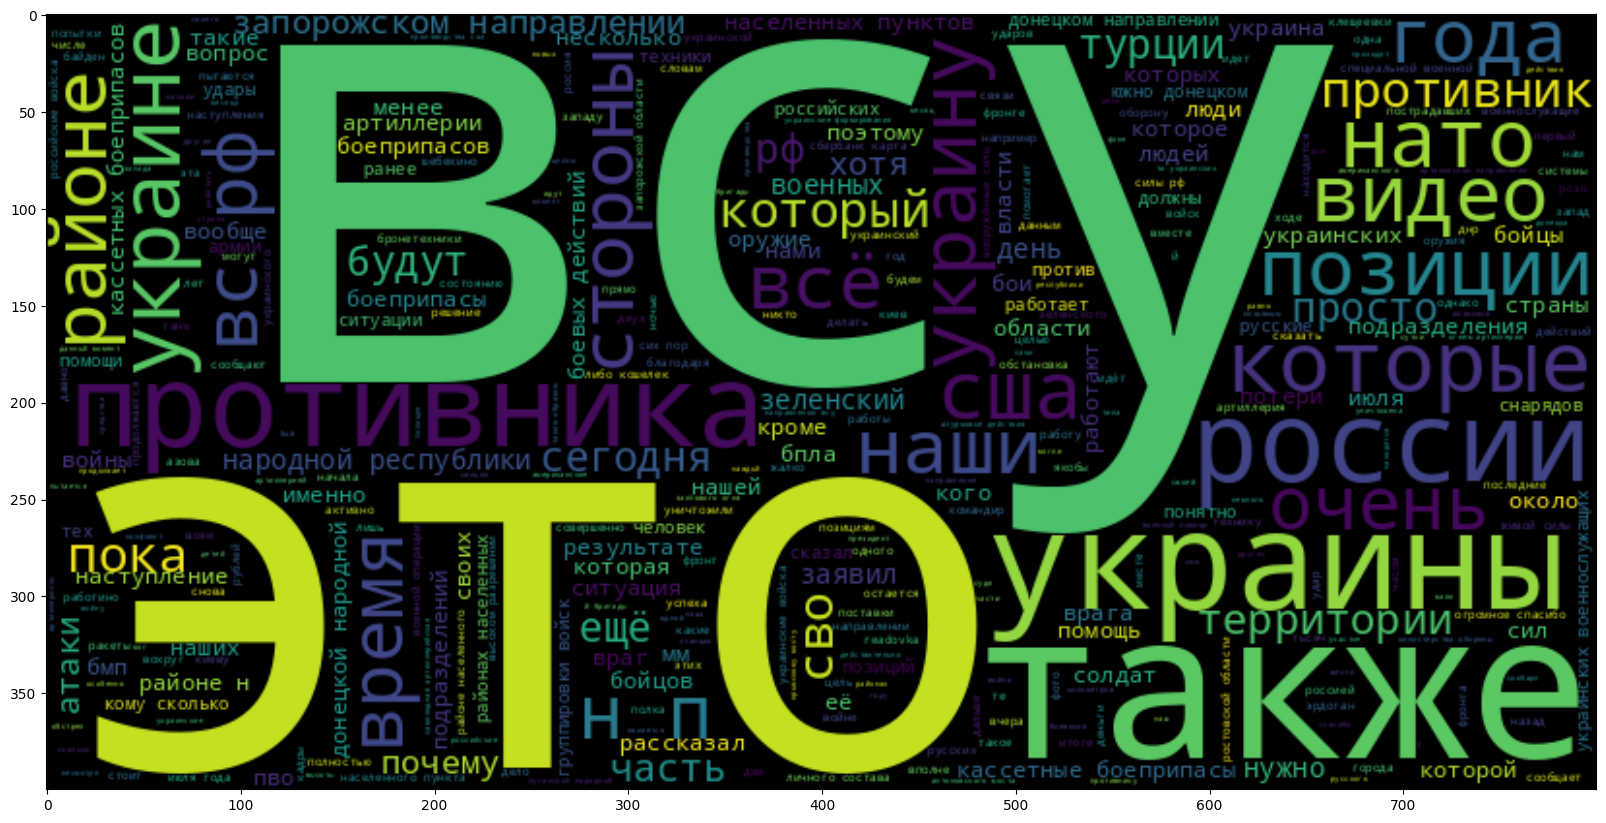

In [12]:
nltk.download("stopwords")

ru_stopwords = stopwords.words("russian")
# ua_stopwords = stopwords.words("ukrainian")

plt.figure(figsize = (20,20)) 
wc = WordCloud(
    max_words = 500, 
    width = 800, 
    height = 400, 
    stopwords = ru_stopwords).generate(" ".join(train_df["Content_processed"].apply(lambda x: str(x).lower())))
plt.imshow(wc, interpolation = 'bilinear')

### Visualizations

In [13]:
device = "cpu"

In [14]:
sent_emb_model = SentenceTransformer("DeepPavlov/rubert-base-cased", device=device)

No sentence-transformers model found with name /Users/danorel/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/danorel/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly iden

In [59]:
train_news_embeddings, train_labels = (
    sent_emb_model.encode(
        train_df["Content_processed"].to_list(), 
        show_progress_bar=True, 
        batch_size=100
    ), 
    train_df["Suspicious_Level"]
)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [60]:
train_tsne_news_embeddings = TSNE(random_state=42).fit_transform(train_news_embeddings)

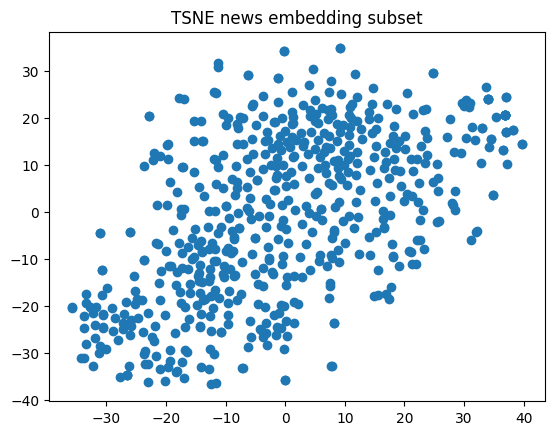

In [61]:
plt.title("TSNE news embedding subset")
plt.scatter(train_tsne_news_embeddings[:,0], train_tsne_news_embeddings[:,1])
plt.show()

In [18]:
k_means = KMeans(
    n_clusters=3, 
    random_state=42, 
    init="k-means++"
)

train_tsne_kmeans_clusts_news_embeddings = k_means.fit_predict(train_tsne_news_embeddings)

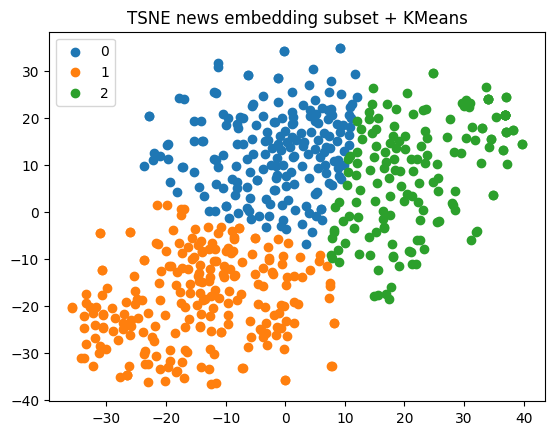

In [67]:
plt.title("TSNE news embedding subset + KMeans")
for clust in np.arange(3):
    plt.scatter(
        train_tsne_news_embeddings[train_tsne_kmeans_clusts_news_embeddings == clust, 0],
        train_tsne_news_embeddings[train_tsne_kmeans_clusts_news_embeddings == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [21]:
train_df[train_tsne_kmeans_clusts_news_embeddings == 2].Content.to_list()[:5]

['–ê–Ω–∫–∞—Ä–∞ –Ω–∞—Ä—É—à–∏–ª–∞ –¥–æ–≥–æ–≤–æ—Ä—ë–Ω–Ω–æ—Å—Ç–∏, –æ—Ç–ø—É—Å—Ç–∏–≤ –≥–ª–∞–≤–∞—Ä–µ–π "–ê–∑–æ–≤–∞" (–∑–∞–ø—Ä–µ—â–µ–Ω –≤ –†–§) –Ω–∞ –£–∫—Ä–∞–∏–Ω—É, –∑–∞—è–≤–∏–ª –æ—Ñ–∏—Ü–∏–∞–ª—å–Ω—ã–π –ø—Ä–µ–¥—Å—Ç–∞–≤–∏—Ç–µ–ª—å –ö—Ä–µ–º–ª—è –î–º–∏—Ç—Ä–∏–π –ü–µ—Å–∫–æ–≤.\n\n–ü–æ –µ–≥–æ —Å–ª–æ–≤–∞–º, —Ç—É—Ä–µ—Ü–∫–∏–µ –≤–ª–∞—Å—Ç–∏ –Ω–µ —Å–æ–æ–±—â–∞–ª–∏ –ú–æ—Å–∫–≤–µ –æ —Å–≤–æ–µ–º —Ä–µ—à–µ–Ω–∏–∏.\n\n–ü–æ–¥–ø–∏—Å–∞—Ç—å—Å—è –Ω–∞ @truekpru',
 '–≠–¢–û –ï–î–ò–ù–°–¢–í–ï–ù–ù–´–ô –°–ü–û–°–û–ë –ü–û–ú–û–ß–¨ –ù–ê–ú! \n\n–ü–æ–ø–æ–ª–Ω–∏—Ç–µ\xa0\xa0 –°–ë–ï–†–ë–ê–ù–ö-–∫–∞—Ä—Ç—É: 4276160925483621\n–ª–∏–±–æ \n‚ÄºÔ∏è–ö–æ—à–µ–ª–µ–∫ –Æ-–ú–∞–Ω–∏: 410012479564046\n\n\n–ö–æ–º—É —Å–∫–æ–ª—å–∫–æ –Ω–µ –∂–∞–ª–∫–æ. –•–æ—Ç—å –ø–æ 10 —Ä—É–±.\n\n–û–≥—Ä–æ–º–Ω–æ–µ —Å–ø–∞—Å–∏–±–æ –∏ –Ω–∏–∑–∫–∏–π –ø–æ–∫–ª–æ–Ω –≤—Å–µ–º –∫—Ç–æ –ø–æ–º–æ–≥–∞–µ—Ç!',
 '–≠–¢–û –ï–î–ò–ù–°–¢–í–ï–ù–ù–´–ô –°–ü–û–°–û–ë –ü–û–ú–û–ß–¨ –ù–ê–ú! \n\n–ü–æ–ø–æ–ª–Ω–∏—Ç–µ\xa0\xa0 –°–ë–ï–†–ë–ê–ù–ö-–∫–∞—Ä—Ç—É: 4276160925483621\n–ª–∏–±–æ \n‚ÄºÔ∏è–ö–æ—à–µ–ª–µ–∫ –Æ-–ú–∞–Ω–∏: 41

### Validation

In [45]:
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
import numpy as np

In [46]:
tsne = TSNE(random_state=42)

train_tsne_news_embeddings = tsne.fit_transform(train_news_embeddings)

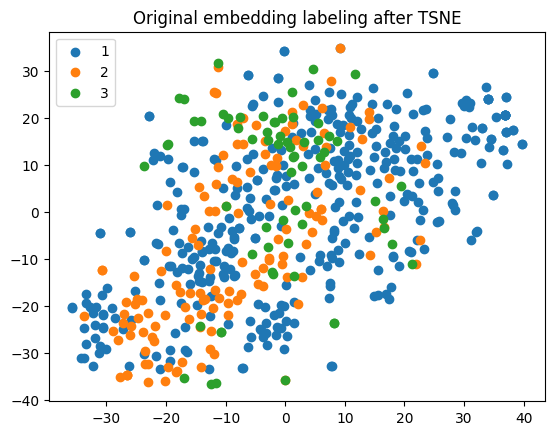

In [64]:
plt.title("Original embedding labeling after TSNE")
for clust in np.arange(1, 4):
    cluster_indices = train_labels.loc[train_labels == clust].index
    label = train_labels[train_df['Suspicious_Level'] == clust]
    plt.scatter(
        train_tsne_news_embeddings[cluster_indices, 0],
        train_tsne_news_embeddings[cluster_indices, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

#### KMeans

In [68]:
# Number of folds (K)
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize a counter for the fold number
fold_number = 1

X = train_df.drop('Suspicious_Level', axis=1)  # Adjust 'target_column' to the actual column name containing your labels

# Labels (y)
y = train_df['Suspicious_Level']

f1_score_folds = []

for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    X_news_embeddings, y_news_embeddings = (
        train_news_embeddings[train_index],
        train_news_embeddings[val_index]
    )
    
    k_means = KMeans(
        n_clusters=3, 
        random_state=42, 
        init="k-means++"
    )
    k_means.fit(X_news_embeddings)
        
    y_pred = k_means.predict(y_news_embeddings).reshape(-1, 1)
    
    # Evaluate the model (e.g., using f1 score)
    f1_score = sklearn.metrics.f1_score(y_val, y_pred, average='macro')
    f1_score_folds.append(f1_score)
    
    # Print the fold number and silhouette score
    print(f"Fold {fold_number} - F1 Score: {f1_score}")
    
    # Compute confusion matrix
    print(sklearn.metrics.classification_report(y_pred, y_val))

    # Increment the fold number
    fold_number += 1
    
f1_mean_score = sum(f1_score_folds) / num_folds
print(f"F1 Score: {f1_mean_score}")

Fold 1 - F1 Score: 0.23631840796019898
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.53      0.72      0.61        57
           2       0.36      0.31      0.33        32
           3       0.00      0.00      0.00         0

    accuracy                           0.43       118
   macro avg       0.22      0.26      0.24       118
weighted avg       0.35      0.43      0.39       118

Fold 2 - F1 Score: 0.25605413105413105
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.66      0.65      0.65        79
           2       0.36      0.38      0.37        26
           3       0.00      0.00      0.00         0

    accuracy                           0.52       118
   macro avg       0.25      0.26      0.26       118
weighted avg       0.52      0.52      0.52       118

Fold 3 - F1 Score: 0.18840579710144928
             

#### SVM

In [69]:
# Number of folds (K)
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize a counter for the fold number
fold_number = 1

X = train_df.drop('Suspicious_Level', axis=1)  # Adjust 'target_column' to the actual column name containing your labels

# Labels (y)
y = train_df['Suspicious_Level']

f1_score_folds = []
misclassified_samples = []

for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    X_news_embeddings, y_news_embeddings = (
        train_news_embeddings[train_index],
        train_news_embeddings[val_index]
    )
    
    # Initialize SVM model
    svm_model = SVC(kernel='linear', random_state=42)
    
    # Train SVM model
    svm_model.fit(X_news_embeddings, y_train)
    
    # Predict using the trained SVM model
    y_pred = svm_model.predict(y_news_embeddings).reshape(-1, 1)
    
    # Evaluate the model (e.g., using f1 score)
    f1_score = sklearn.metrics.f1_score(y_val, y_pred, average='macro')
    f1_score_folds.append(f1_score)
    
    # Print the fold number and f1 score
    print(f"Fold {fold_number} - F1 Score: {f1_score}")
    
    # Compute confusion matrix
    print(sklearn.metrics.classification_report(y_pred, y_val))

    # Increment the fold number
    fold_number += 1

f1_mean_score = np.mean(f1_score_folds)
print(f"F1 Score: {f1_mean_score}")

Fold 1 - F1 Score: 0.6368717111232081
              precision    recall  f1-score   support

           1       0.95      0.81      0.87        90
           2       0.50      0.88      0.64        16
           3       0.38      0.42      0.40        12

    accuracy                           0.78       118
   macro avg       0.61      0.70      0.64       118
weighted avg       0.83      0.78      0.79       118

Fold 2 - F1 Score: 0.7405934343434343
              precision    recall  f1-score   support

           1       0.84      0.89      0.87        73
           2       0.82      0.64      0.72        36
           3       0.54      0.78      0.64         9

    accuracy                           0.81       118
   macro avg       0.73      0.77      0.74       118
weighted avg       0.81      0.81      0.80       118

Fold 3 - F1 Score: 0.6460561772094086
              precision    recall  f1-score   support

           1       0.86      0.87      0.86        75
           2   

### Submission

In [72]:
test_df["Content_processed"] = test_df["Content"].apply(process_text)

test_news_embeddings = sent_emb_model.encode(
    test_df["Content_processed"].to_list(), 
    show_progress_bar=True, 
    batch_size=100
)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [74]:
y_train = train_df['Suspicious_Level']
s
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(train_news_embeddings, y_train)

y_pred = svm_model.predict(train_news_embeddings).reshape(-1, 1)

print(sklearn.metrics.classification_report(y_pred, y_train))

test_df['Suspicious_Level'] = svm_model.predict(test_news_embeddings).reshape(-1, 1)

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       385
           2       0.98      0.99      0.99       137
           3       0.98      0.98      0.98        65

    accuracy                           0.99       587
   macro avg       0.99      0.99      0.99       587
weighted avg       0.99      0.99      0.99       587



In [75]:
test_df

ChannelName   ChannelId  MessageId                 Date  \
0           ukraina_ru  1175084215     168641  2023-09-11 16:57:36   
1              bear007  1505866568      36569  2023-09-11 14:52:01   
2       zakharprilepin  1217080686      19697  2023-09-11 08:26:09   
3            denazi_ua  1783083983      49296  2023-09-11 12:30:37   
4           spletnicca  1287596810      11784  2023-09-11 08:47:19   
...                ...         ...        ...                  ...   
1166  istorijaoruzijaz  1619447075      47454  2023-09-11 12:54:21   
1167           rian_ru  1101170442     214788  2023-09-11 03:01:27   
1168          stranaua  1092413834     122190  2023-09-11 05:07:28   
1169       rezident_ua  1271765197      19610  2023-09-11 13:08:45   
1170       tsibulya_ua  1494993138      15658  2023-09-11 03:18:59   

                 EditDate                                            Content  \
0     2023-09-11 16:57:50  ‚ö°Ô∏è–ê–¥–º–∏–Ω–∏—Å—Ç—Ä–∞—Ü–∏—è –ë–∞–π–¥–µ–Ω–∞ –±–ª–∏–∑–∫–∞ –∫ —Ç–æ–º—É, —á—Ç–æ–±—ã –æ...   
1     2023-09-11 14:52:12  –†–ò–ê –ù–æ–≤–æ—Å—Ç–∏ –ø—É–±–ª–∏–∫—É–µ—Ç –ø–µ—Ä–≤—ã–µ –∫–∞–¥—Ä—ã —Å –º–µ—Å—Ç–∞ –≥–∏–±...   
2                     NaN  –í–∏—Ü–µ-—Å–ø–∏–∫–µ—Ä –ì–æ—Å–¥—É–º—ã –ü–µ—Ç—Ä –¢–æ–ª—Å—Ç–æ–π - –æ —Å—Ä–æ–∫–∞—Ö –æ–∫...   
3     2023-09-11 12:32:55  –í –ì–µ—Ä–º–∞–Ω–∏–∏ –Ω–µ –æ—Å—Ç–∞–ª–æ—Å—å –¥–µ–π—Å—Ç–≤—É—é—â–∏—Ö —Å–ø–µ—Ü–∏–∞–ª–∏—Å—Ç–æ...   
4                     NaN  –í–æ–µ–Ω–Ω—ã–µ –º–µ–¥–∏–∫–∏ —Ä–∞—Å—Å–∫–∞–∑–∞–ª–∏ –ø—Ä–∞–≤–¥—É –æ –≤–æ–π–Ω–µ –∏ –µ—ë ...   
...                   ...                                                ...   
1166  2023-09-11 12:55:17                                     üòÇüòé —Ñ–∏–Ω–∞–ª –æ–≥–æ–Ω—å   
1167                  NaN  –§–∞–∫—Ç–æ—Ä—ã —Å–µ–π—á–∞—Å —Å–∫–ª–∞–¥—ã–≤–∞—é—Ç—Å—è –≤ –ø–æ–ª—å–∑—É —É–∫—Ä–µ–ø–ª–µ–Ω–∏...   
1168                  NaN  –ü–æ –ß–µ—Ä–Ω–∏–≥–æ–≤—Å–∫–æ–π –æ–±–ª–∞—Å—Ç–∏ –Ω–æ—á—å—é –±—ã–ª –Ω–∞–Ω–µ—Å–µ–Ω —É–¥–∞—Ä...   
1169                  NaN  –û—Ñ–∏—Å –ü—Ä–µ–∑–∏–¥–µ–Ω—Ç–∞ –Ω–µ —Å–º–æ–≥ —Å–º–µ—Å—Ç–∏—Ç—å –∞–∫—Ü–µ–Ω—Ç—ã —Å –ó–µ–ª...   
1170  2023-09-11 03:20:22  ‚ùóÔ∏è–ù–∞—à–∏ –æ—Ç–Ω–æ—à–µ–Ω–∏—è —Å –ü–æ–ª—å—à–µ–π –æ–±–æ—Å—Ç—Ä—è—é—Ç—Å—è. –ü–æ–ª—å—Å–∫...   

                                      Content_processed  Suspicious_Level  
0     –ê–¥–º–∏–Ω–∏—Å—Ç—Ä–∞—Ü–∏—è –ë–∞–π–¥–µ–Ω–∞ –±–ª–∏–∑–∫–∞ –∫ —Ç–æ–º—É, —á—Ç–æ–±—ã –æ–¥–æ...                 2  
1     –†–ò–ê –ù–æ–≤–æ—Å—Ç–∏ –ø—É–±–ª–∏–∫—É–µ—Ç –ø–µ—Ä–≤—ã–µ –∫–∞–¥—Ä—ã —Å –º–µ—Å—Ç–∞ –≥–∏–±...                 1  
2     –í–∏—Ü–µ-—Å–ø–∏–∫–µ—Ä –ì–æ—Å–¥—É–º—ã –ü–µ—Ç—Ä –¢–æ–ª—Å—Ç–æ–π - –æ —Å—Ä–æ–∫–∞—Ö –æ–∫...                 2  
3     –í –ì–µ—Ä–º–∞–Ω–∏–∏ –Ω–µ –æ—Å—Ç–∞–ª–æ—Å—å –¥–µ–π—Å—Ç–≤—É—é—â–∏—Ö —Å–ø–µ—Ü–∏–∞–ª–∏—Å—Ç–æ...                 3  
4     –í–æ–µ–Ω–Ω—ã–µ –º–µ–¥–∏–∫–∏ —Ä–∞—Å—Å–∫–∞–∑–∞–ª–∏ –ø—Ä–∞–≤–¥—É –æ –≤–æ–π–Ω–µ –∏ –µ—ë ...                 1  
...                                                 ...               ...  
1166                                        —Ñ–∏–Ω–∞–ª –æ–≥–æ–Ω—å                 1  
1167  –§–∞–∫—Ç–æ—Ä—ã —Å–µ–π—á–∞—Å —Å–∫–ª–∞–¥—ã–≤–∞—é—Ç—Å—è –≤ –ø–æ–ª—å–∑—É —É–∫—Ä–µ–ø–ª–µ–Ω–∏...                 1  
1168  –ü–æ –ß–µ—Ä–Ω–∏–≥–æ–≤—Å–∫–æ–π –æ–±–ª–∞—Å—Ç–∏ –Ω–æ—á—å—é –±—ã–ª –Ω–∞–Ω–µ—Å–µ–Ω —É–¥–∞—Ä...                 1  
1169  –û—Ñ–∏—Å –ü—Ä–µ–∑–∏–¥–µ–Ω—Ç–∞ –Ω–µ —Å–º–æ–≥ —Å–º–µ—Å—Ç–∏—Ç—å –∞–∫—Ü–µ–Ω—Ç—ã —Å –ó–µ–ª...                 1  
1170  –ù–∞—à–∏ –æ—Ç–Ω–æ—à–µ–Ω–∏—è —Å –ü–æ–ª—å—à–µ–π –æ–±–æ—Å—Ç—Ä—è—é—Ç—Å—è. –ü–æ–ª—å—Å–∫–∏–π...                 1  

[1171 rows x 8 columns]

In [78]:
test_df[['MessageId', 'Suspicious_Level']].to_csv('submission.csv', index=False)